In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

# Coding the algorithm

In [2]:
# A class which evaluates to a normalised gaussian function in 2D space. 
class Gaussian2D:
  def __init__(self, width, origin):
    self.width = width # waist width
    self.origin = np.array(origin) # origin in tuple like (x0, y0)

  def __call__(self, x, y):
    r = (x-self.origin[0]) ** 2 + (y - self.origin[1]) ** 2
    return np.exp(- r / self.width**2) / (np.pi * self.width ** 2)

In [1]:
# Class which generates random phase screens
# The algorithm comes the from Martin and Flatté papaer

class PhaseScreen:
    def __init__(self, L, Z, Nz, Nx, k, C_n, L_0, kappa):
        self.Nx = Nx
        
        # Pre computing some values which remain constant throughout the propagation
        self.dkappa = 2 * np.pi / L
        Phi_n = 0.033 * C_n * (kappa ** 2 + 1/(L_0**2)) ** (-11/6)
        self.Phi_theta = 2 * np.pi * k ** 2  * Phi_n * Z / Nz

    def randmatrix(self):
        A, B = np.random.normal(size=(self.Nx,self.Nx)), np.random.normal(size=(self.Nx,self.Nx))
        noise = (A + 1j*B) * np.sqrt(self.Phi_theta) / self.dkappa
        noisefourier = 2 * np.pi * np.fft.ifft2(noise) * Nx ** 2 / (L ** 2)
        return noisefourier.real

In [4]:
# Spectral class which propagates the beam
# This is the bulk of the algorithm

class Spectral:
  def __init__(self, L, Z, Nz, Nx, k, C_n, L_0, N_int=2**5):
        self.L = L # Size of the spatial grids (m)
        self.Nz = Nz # Subdivision of the propagation axis and number of screens
        self.Nx = Nx # Subdivision of the spatial and spectral grids
        self.k = k # Wavenumber (m^-1)
        self.N_int = N_int # Number of steps to save
        self.Z = Z # Final observation height (m)
        self.dZ = self.Z / self.Nz # Z-interval
        
        # Spatial grid
        _range_spatial = np.linspace(-L/2, L/2, num = self.Nx, endpoint=False)
        self.x, self.y = np.meshgrid(_range_spatial, _range_spatial)

        # Spectral grid
        spacing = L/self.Nx
        _range_spectral = 2 * np.pi * np.fft.fftfreq(self.Nx, d=spacing)
        self.kappax, self.kappay = np.meshgrid(_range_spectral, _range_spectral)
        
        # Pre-computing
        self.kappa = (self.kappax ** 2 + self.kappay ** 2) ** 0.5
        self.fourier_mult = np.exp(-1j * self.kappa ** 2 * self.dZ / (2 * self.k))

        # Array allocation
        # Self.u The matrix which stores the complex electric field amplitude in the spatial grid. 
        self.u = np.zeros([self.Nx, self.Nx], dtype=complex)
        # Self.evol stores self.u N_int times along the propagation, as well as it's initial value. 
        self.evol = np.zeros([self.N_int + 1, self.Nx, self.Nx], dtype=complex)
        
        
        # Initialise the phase screen class
        self.phase_screen = PhaseScreen(L, Z, Nz, Nx, k, C_n, L_0, self.kappa)
        
  # Setting the initial shape of the beam - the input typically comes from Gaussian2D
  def initialize(self, u0):
      self.u = u0

  # Increments the propagation from z to z+dz
  # Phase determines whether to use phase screens
  def step(self, phase=True):
      if phase:
          phase_mult = np.exp(1j * self.phase_screen.randmatrix())
          
          self.u = np.fft.ifft2(np.fft.fft2(self.u * phase_mult) * self.fourier_mult)
      else:
          self.u = np.fft.ifft2(np.fft.fft2(self.u) * self.fourier_mult)
  
  # Calls step Nz times to propagate the beam fully
  # Along the way, it saves some steps in self.evol, and prints progress for when the computations are long
  def advance(self, phase=True):
      for i in range(self.Nz):
          # Saving
          if i % (self.Nz // self.N_int) == 0:
              self.evol[self.N_int * i // self.Nz] = self.u
          # Making the step
          self.step(phase)
          # Run progress
          if i % (self.Nz // 10) == 0:
              print(100 * i // Nz, '%')
      # Saving the last value
      self.evol[-1] = self.u



In [5]:
# Diagnostics
# Calculating Intensity, power, com, width

# For 2D matrices like Spectral.u
def Diag2D(u, x, y):
    dxdy = (x[0, 1] - x[0, 0]) * (y[1, 0] - y[0, 0])
    I = u ** 2
    p = np.sum(I)
    x_c, y_c = np.sum(x*I) / p, np.sum(y*I) / p
    d = (x-x_c) ** 2 + (y-y_c) ** 2
    return I, p * dxdy, x_c, y_c, (2 * np.sum(d * I) / p) ** 0.5

# For 3D matrices like Spectral.u_evol
def Diag3D(evol, x, y):
    dxdy = (x[0, 1] - x[0, 0]) * (y[1, 0] - y[0, 0])
    I = evol ** 2
    
    p = np.sum(I, axis=(1, 2))
    
    x_c = np.sum(x*I, axis=(1,2)) / p
    y_c = np.sum(y*I, axis=(1,2)) / p
    
    d = (x-x_c[:, None, None]) ** 2 + (y-y_c[:, None, None]) ** 2
    
    return I, p * dxdy, x_c, y_c, (2 * np.sum(d * I, axis=(1, 2)) / p) ** 0.5

In [6]:
# 2D analytical solution to the pure diffusion equation

def analytical(x, y, width, x0, y0, U_0, Z, Nz,  k):
    D = 1j / (2 * k)
    Z_arr = np.linspace(0, Z, Nz)[:, None, None]
    
    sigma = width ** 2  + 4 * D * Z_arr 
    
    norm_factor = U_0 / (np.pi * sigma)
    
    exponent = -((x - x0)**2 + (y - y0)**2) / sigma
    
    return np.abs(norm_factor * np.exp(exponent))

# Running the simulation
In the first cell we set the parameters and initial conditions. We then initialise the algorithm. We also run diagnostics about how valid our assumptions are in these conditions. 

In [33]:
# Simulation parameters
Nz = 2 ** 8
Nx = 2 ** 11

L = 0.7 # m

N_int = 2**5

# Physical parameters
Z = 1500 # m
L_0 = 1 # m

# C_n = 4E-16 
C_n = 5E-14
wavelength = 7E-7 # m

w_0 = 0.002 # m
A = 1 # 

k = 2 * np.pi / wavelength

phase = True
# phase = True

# Initialization

Z_r = 0.5 * k * w_0 ** 2
w_z = w_0 * np.sqrt(1+(Z/Z_r)**2)
# assert L >= 4 * w_z
# L = 4 * w_z

print(f'Z_r = {Z_r*1E-3:.2f} km, L = {L:.2g}m, w_z = {w_z:.2g} m')

s = Spectral(L, Z, Nz, Nx, k, C_n, L_0, N_int)
g = Gaussian2D(w_0, (0, 0))

s.initialize(g(s.x, s.y)) # initialize to a 2D Gaussian

Z_r = 0.02 km, L = 0.7m, w_z = 0.17 m


In [31]:
# Propagation Diagnostics:
'''
1. There should be 10 baskets within the initial waist width
2. The final size of the beam should be 1/4 of L
3. Z_r should be big, at least compared to Z
'''

if L / Nx > w_0 / 10:
    print(f'!Spatial grid spacing is {(10 * L)/(Nx * w_0):.2g}x too big: dx = {L / Nx :.2g} m >= {w_0 / 10 :.2g} m = w_0/10')

if w_z > L/4:
    print(f'!Spatial grid is too small. The final width {w_z:.2g} m will not fit in the box of size L = {L:.2g} m')
    

# if Z/Z_r >= 20:
#     print(f'Warning: Z = {Z*1E-3:.2g} km is much bigger than Z_r = {Z_r * 1E-3:.2g} km, so the beam width will significantly increase. This may be computationally inefficient')
    
# assert Nx < 2 ** 12, "Too much storage, too slow to run"


!Spatial grid spacing is 1.7x too big: dx = 0.00034 m >= 0.0002 m = w_0/10


In [32]:
# Phase screen Diagnostics: 
'''
delta_phi = k_0 * n(x, y) delta_z <= 2 * pi / 10
Must always be satisfied, with the max amplitude of n(x, y)
This is the same as our randmatrix() output, but take max over (x, y)
'''

m = np.max([np.abs(s.phase_screen.randmatrix()) for _ in range(10)])
dz_bound = (0.2 * np.pi) * Z/(Nz * m)

if m > 0.2 * np.pi:
    print('Interscreen distance too big')
    print(f'Bound: {dz_bound:.2g} versus current value {Z/Nz:.2g}')


**Run the algorithm in this cell**

In thiscell we run the bulk of the algorithm - the longest and most computationally expensive part. 
We then save the results (the array of the amplitude evolution) into a file. 

The results are saved in the file, make sure not to overwrite another result when doing so. 
The parameters are also saved into the file. 
Progress of the algorithm is indicated to estimate ETA, but not progress in saving the file!

In [ ]:
import os
filename = 'saves/low_laser_pointer3.npz'

assert(not os.path.exists(filename)) 

s.advance(phase)

np.savez_compressed(filename, 
         u_evol = np.abs(s.evol), 
         L = L, Z = Z, Nz = Nz, Nx = Nx, k = k, C_n = C_n, L_0 = L_0, w_0 = w_0, A = A, phase=phase)

0 %


# Visualising and studying the results

Loading the results. 

In [13]:
name = 'low_laser_pointer2'
file = np.load(f"saves/{name}.npz")
u_evol, L, Z, Nz, Nx, k, C_n, L_0, w_0, A = file['u_evol'], file['L'], file['Z'], file['Nz'], file['Nx'], file['k'], file['C_n'], file['L_0'], file['w_0'], file['A']
phase = file['phase']

_range_spatial = np.linspace(-L/2, L/2, num = Nx, endpoint=False)
Xgrid, Ygrid = np.meshgrid(_range_spatial, _range_spatial)

# N_int = Nb_evol
Nb_evol = u_evol.shape[0]

u_analytical = analytical(Xgrid, Ygrid, w_0, 0, 0, A, Z, Nb_evol, k)

# Discretized array for Z axis
Z_arr = np.linspace(0, Z, Nb_evol)

# Rayleigh length
Z_r = k * w_0 ** 2 / 2
# Expected final width of gaussian beam
w_z = w_0 * np.sqrt(1+(Z/Z_r)**2)

# This is the initial peak amplitude. Use this for normalising in graphs. 
h0 = u_evol[0, Nx//2, Nx//2]

# Annotation
annotation = f"Nz = {Nz}; Nx = {Nx}; L = {L} m; Z = {Z:.1E} m; L_0 = {L_0} m; C_n = {C_n:.1E}; lambda = {2*np.pi/k:.1E} m; w_0 = {w_0*1E3:.2g} mm; phase = {phase}"
annotation

'Nz = 256; Nx = 1024; L = 0.5 m; Z = 1.0E+03 m; L_0 = 1 m; C_n = 4.0E-16; lambda = 7.0E-07 m; w_0 = 2 mm; phase = True'

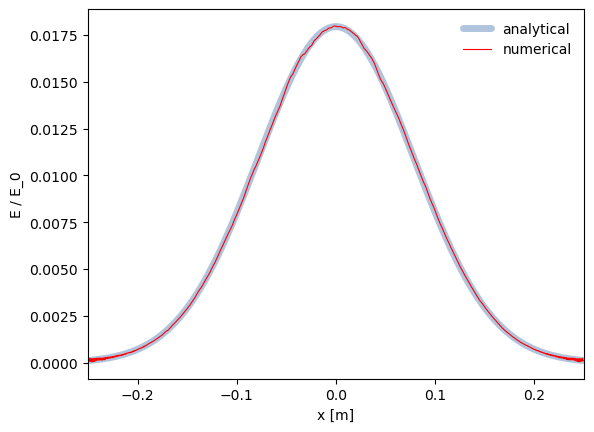

In [15]:
'Wave envelopes 2D'

bound = L/2

# Initial beam
# plt.plot(Xgrid[0], u_analytical[0][:, Nx//2]/h0, color='lightsteelblue', solid_capstyle='round', linewidth=5, label='analytical')
# plt.plot(Xgrid[0], u_evol[0][:, Nx//2]/h0, color='red', lw=0.8, label='numerical')

plt.plot(Xgrid[0], u_analytical[Nb_evol -1][:, Nx//2]/h0, color='lightsteelblue', solid_capstyle='round', linewidth=5, label='analytical')
plt.plot(Xgrid[0], u_evol[Nb_evol - 1][:, Nx//2]/h0, color='red', lw=0.8, label='numerical')

plt.ylabel('E / E_0')
plt.xlabel('x [m]')
plt.xlim(-bound, bound)
plt.legend(frameon=False)
# plt.title("Comparing wave projections")

In [ ]:
# Error between analytical and numerical solution
# Useful only in absence of phase screens

plt.title('Error')

e = np.abs((u_evol - u_analytical))
err_evol = np.sum(e, axis=(1, 2)) / np.sum(u_analytical, axis=(1, 2))
plt.semilogy(Z_arr, err_evol)

Text(0.5, 0, 'Electric field amplitude')

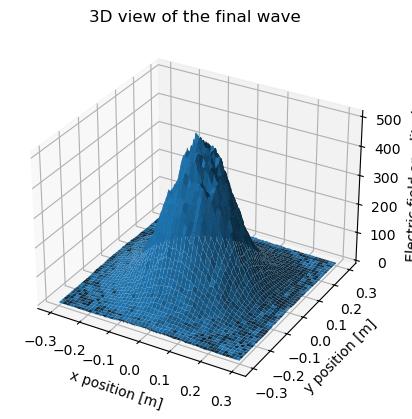

In [62]:
'Surface plot of propagated wave'

fig = plt.figure()
ax3d = fig.add_subplot(projection='3d')

ax3d.plot_surface(Xgrid, Ygrid, u_evol[-1])

ax3d.set_xlabel("x position [m]")
ax3d.set_ylabel("y position [m]")
ax3d.set_zlabel("Electric field amplitude")

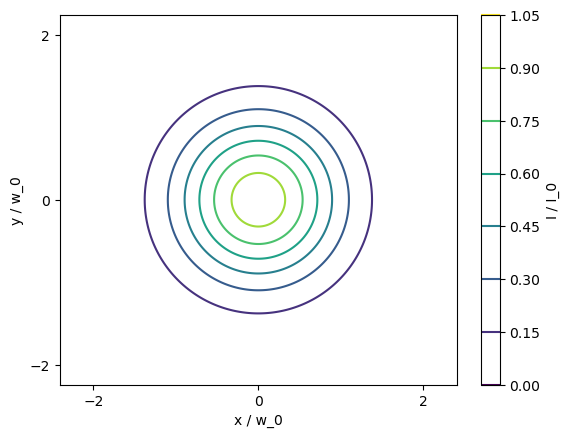

In [50]:
'Contour plot'

plt.contour(Xgrid/w_0, Ygrid/w_0, u_analytical[-1]/h0)
cb = plt.colorbar(label='I / I_0')
plt.xlabel('x / w_0')
plt.ylabel('y / w_0')
plt.axis('equal')
plt.locator_params(nbins=4)

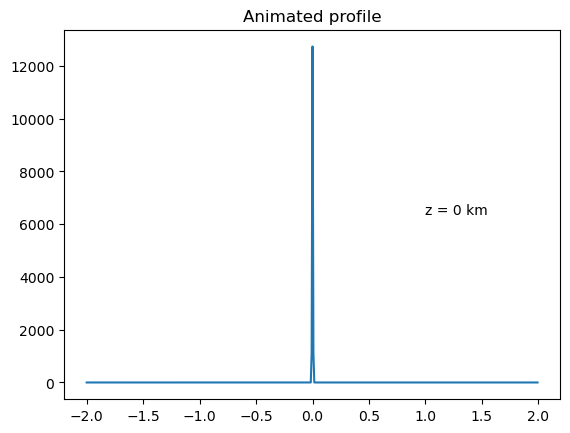

In [35]:
'Animated envelope 2D'

fig , ax = plt.subplots()

m = np.max(u_evol)

line1, = ax.plot(Xgrid[0], u_evol[0, :, Nx//2], label='numerical')
ax.set_title("Animated profile")

def animate(i):
    global line1
    line1.set_data(Xgrid[0], u_evol[i, :, Nx//2])

anim = FuncAnimation(fig, animate, frames=range(Nb_evol))
anim.save("vid.mp4", fps=Nb_evol//10)

In [16]:
'Computing diagnostics'

I, power, x_c, y_c, widths = Diag3D(u_evol, Xgrid, Ygrid)
I_a, power_a, x_ca, y_ca, widths_a = Diag3D(u_analytical, Xgrid, Ygrid)


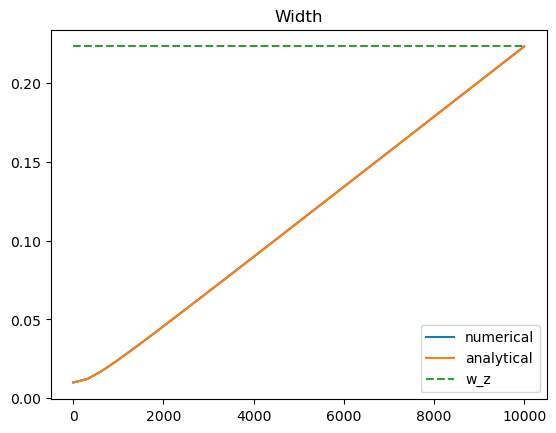

In [135]:
# Width
plt.plot(Z_arr, widths, label='numerical')
plt.plot(Z_arr, widths_a, label='analytical')
plt.plot(Z_arr, w_z * np.ones_like(Z_arr), '--', label='w_z')

plt.legend()


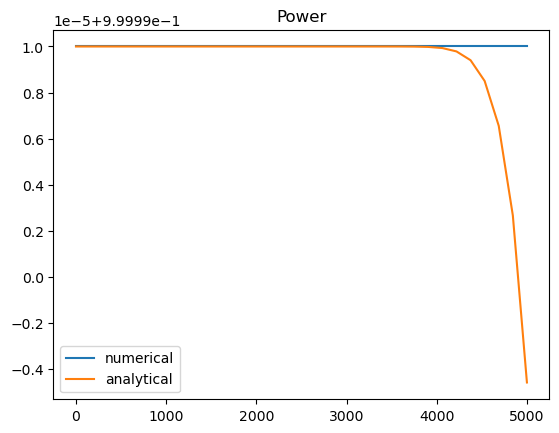

In [21]:
# Power
plt.plot(Z_arr, power/power[0], label='numerical')
plt.plot(Z_arr, power_a/power_a[0], label='analytical')
plt.legend()

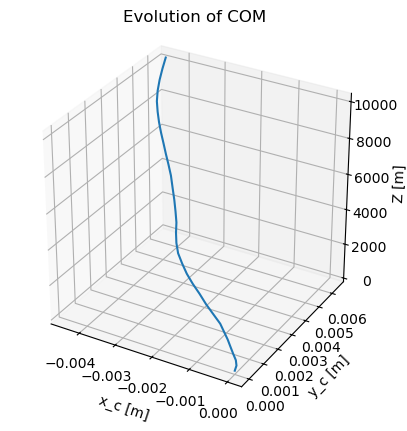

In [158]:
'Plotting evolution of COM'

fig = plt.figure()
ax3d = fig.add_subplot(projection='3d')
ax3d.set_aspect('equal')

ax3d.plot(x_c, y_c, Z_arr)
ax3d.set_xlabel("x_c [m]")
ax3d.set_ylabel("y_c [m]")
ax3d.set_zlabel("Z [m]")

In [ ]:
# Plotting intensity

red = LinearSegmentedColormap.from_list('red', ['k', 'r'])

plt.pcolormesh(Xgrid/w_0, Ygrid/w_0, I[-1], cmap=red)
ax=plt.gca()
# plt.axis('off')
plt.axis('equal')
ax.set_aspect('equal', adjustable='box')
plt.locator_params(nbins=4)
plt.colorbar(label='I / I_0')
plt.xlabel('x / w_0')
plt.ylabel('y / w_0')

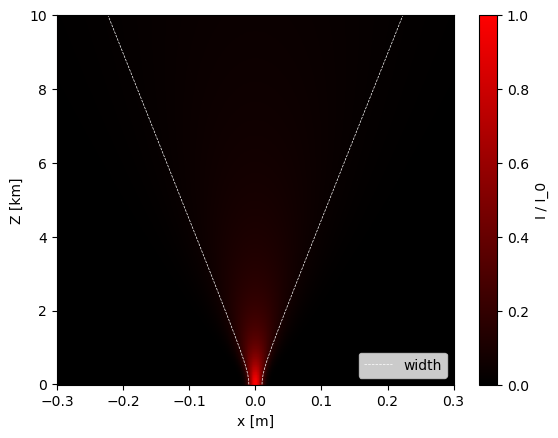

In [65]:
xrange = np.linspace(-w_z, w_z, Nx)
zrange = np.linspace(0, Z/1000, N_int)
an = analytical1D(xrange, w_0, Z, N_int, k)

w = w_0 * np.sqrt(1 + (1000 * zrange / Z_r) ** 2)

red = LinearSegmentedColormap.from_list('red', ['k', 'r'])

tXgrid, Zgrid = np.meshgrid(xrange, zrange)
plt.pcolormesh(tXgrid, Zgrid, (an ** 2) / an[0, Nx//2] ** 2, cmap=red)
plt.plot(-w, zrange, linestyle='--', linewidth=0.5, color='w', label='width')
plt.plot(w, zrange, linestyle='--', linewidth=0.5, color='w')

plt.ylabel('Z [km]')
plt.xlabel('x [m]')
plt.legend(loc='lower right')
plt.colorbar(label='I / I_0')

# Coding statistics

In [55]:
n = 20

# Simulation parameters
Nz = 2 ** 10
Nx = 2 ** 10
L = 1 # m
N_int = 2**5
# Physical parameters
Z = 10000 # m
L_0 = 1 # m
wavelength = 7E-7 # m
w_0 = 0.01 # m
A = 1 # 
k = 2 * np.pi / wavelength
phase = True

C_n = np.array([8E-18, 4E-16, 5E-14])
label = np.array(['low', 'medium', 'high'])
colors = ['green', 'orange', 'red']

In [ ]:
# For running the algorithm multiple times and saving all the runs in separate files

for i in range(3):
    for j in range(0, n):
        s = Spectral(L, Z, Nz, Nx, k, C_n[i], L_0, N_int)
        g = Gaussian2D(w_0, (0, 0))
        s.initialize(g(s.x, s.y))
        s.advance(phase)
        
        np.savez_compressed(f'{label[i]}/run{j:02}.npz', 
             u_evol = np.abs(s.evol), 
             L = L, Z = Z, Nz = Nz, Nx = Nx, k = k, C_n = C_n[i], L_0 = L_0, w_0 = w_0, A = A, phase=phase)

In [112]:
# For processing only the diagnostics and saving into a much smaller file
_range_spatial = np.linspace(-L / 2, L / 2, num=Nx, endpoint=False)
Xgrid, Ygrid = np.meshgrid(_range_spatial, _range_spatial)

q = np.zeros((3, n, 4, N_int+1))

for i in range(3):
    for j in range(n):
        file = np.load(f"{label[i]}/run{j:02}.npz")
        I, p, x, y, r = Diag3D(file['u_evol'], Xgrid, Ygrid)
        q[i, j] = np.array([p, x, y, r])
    
np.savez_compressed(
    'combined.npz', 
    low=q[0], high=q[1], medium=q[2],
    L = L, Z = Z, Nz = Nz, Nx = Nx, k = k, C_n = C_n, L_0 = L_0, w_0 = w_0, A = A, phase=phase
    )


In [8]:
# For drawing multicolored lines - credit to StackOverflow
def colored_line(x, y, c, ax, **lc_kwargs):
    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
    
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)

    return ax.add_collection(lc)

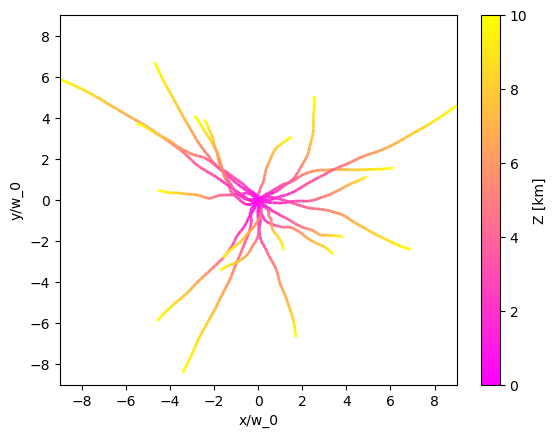

In [129]:
# For graphing the trajectories
file = np.load('combined.npz')

q = np.array([file['low'], file['medium'], file['high']])

i = 2
color = np.linspace(0, Z/1000, N_int+1)
fig1, ax1 = plt.subplots()
for j in range(20):
    p, x, y, w = q[i, j]
    lines = colored_line(x/w_0, y/w_0, color, ax1, linewidth=2, cmap="spring")

fig1.colorbar(lines, label='Z [km]')

ax1.set_ylabel('y/w_0')
ax1.set_xlabel('x/w_0')

['low' 'medium' 'high']
[0.05461998 0.47921692 5.98827422]
[0.02646749 0.22323694 2.27430337]


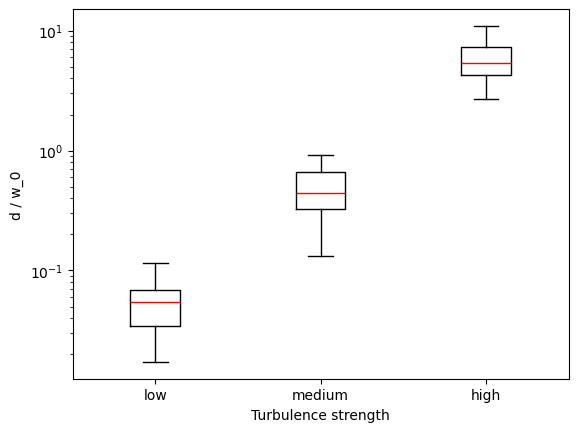

In [53]:
# Quantitative stats
file = np.load('combined.npz')

q = np.array([file['low'], file['medium'], file['high']])

end_x = q[:, :, 1, -1]
end_y = q[:, :, 2, -1]

# Calculating deviation
d = np.sqrt(end_x ** 2 + end_y **2) / w_0

# Box and whisker plot
box = plt.boxplot(d.transpose(), tick_labels=['low', 'medium', 'high'])
ax = plt.gca()
ax.set_yscale('log')
plt.xlabel('Turbulence strength')
plt.ylabel('d / w_0')

for median in box['medians']:
    median.set_color('red')

# Outputting numerical data
print(label)
print(np.mean(d, axis=1))
print(np.std(d, axis=1))